In [ ]:
import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer # lemmeatizer
from nltk.tokenize import word_tokenize
from textblob import Word
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import StringLookup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fin_data = pd.read_csv("/content/drive/MyDrive/fin_data.csv")
positive = pd.read_csv("/content/drive/MyDrive/articles.csv")
print(fin_data.columns)
print(positive.columns)

Index(['Sentence', 'Sentiment'], dtype='object')
Index(['title', 'content'], dtype='object')


In [ ]:
positive['Sentiment'] = 'positive'

In [ ]:
# take half of positive and merge the title portion and the content portion into the fin_data, separately
rows = positive.shape[0]
merge = positive.iloc[:int(rows/2)]

In [ ]:
# the left part of the positive table will be used for testing set
test = positive.iloc[int(rows/2):]

In [ ]:
# title merge
title = merge[['title', 'Sentiment']]
title.rename(columns = {'title': 'Sentence'}, inplace = True)
data_t = pd.concat([fin_data, title], axis = 0)
data_t = data_t.reset_index()
data_t.drop(columns = 'index', inplace = True)
data_t = data_t.sample(frac=1)
data_t.head()

,Sentence,Sentiment
1973,@pierrules: $SIRI LONG!!,positive
6631,This is the Largest Village Built Exclusively ...,positive
1206,Finnish IT solutions provider Affecto Oyj HEL ...,negative
869,Is Trouble Brewing At Legal & General Group Pl...,negative
2797,Operating loss totaled EUR 25mn compared to a ...,neutral


In [ ]:
# baseline prediction
baseline = data_t.groupby("Sentiment").apply(len)
negative = baseline[0]
neutral = baseline[1]
positive = baseline[2]
baseline_pred = max(negative, neutral, positive) / np.sum([negative, neutral, positive])
baseline_pred

0.4417784050811574

In [ ]:
# labeling train set
le = LabelEncoder()
data_t['Category'] = le.fit_transform(data_t['Sentiment'])
data_t.head()

,Sentence,Sentiment,Category
1973,@pierrules: $SIRI LONG!!,positive,2
6631,This is the Largest Village Built Exclusively ...,positive,2
1206,Finnish IT solutions provider Affecto Oyj HEL ...,negative,0
869,Is Trouble Brewing At Legal & General Group Pl...,negative,0
2797,Operating loss totaled EUR 25mn compared to a ...,neutral,1


In [ ]:
# title test
title_test = test[['title', 'Sentiment']]
title_test.rename(columns = {'title' : 'Sentence'}, inplace = True)
title_test.head()

,Sentence,Sentiment
1243,$600K Awarded to Mobile Tech Innovators Helpin...,positive
1244,Ontario is First Region in North America to Cu...,positive
1245,"US Moves to Phase out Trans Fats From Food, Ci...",positive
1246,"Airport Not Only Returns Lost Toy, It Makes Pi...",positive
1247,"With Fins Off the Menu, A Glimmer of Hope for ...",positive


In [ ]:
# labeling test set
title_test['Category'] = le.fit_transform(title_test['Sentiment']) + 2
title_test.head()

,Sentence,Sentiment,Category
1243,$600K Awarded to Mobile Tech Innovators Helpin...,positive,2
1244,Ontario is First Region in North America to Cu...,positive,2
1245,"US Moves to Phase out Trans Fats From Food, Ci...",positive,2
1246,"Airport Not Only Returns Lost Toy, It Makes Pi...",positive,2
1247,"With Fins Off the Menu, A Glimmer of Hope for ...",positive,2


In [ ]:
# clean text so that no capitalized letter and no stopping words

# Lemmatizer
# before adding lemmatizer, it's 76% for title and 78% for content on test set
# after adding lemmatizer, it increases to 89% for title and 88% for content on the test set
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK's POS tags to WordNet's format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# for .apply()
def lemma(x):
  tokens = word_tokenize(x)
  tagged = nltk.pos_tag(tokens)
  lemmatized_sentence = []

  for word, tag in tagged:
    wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN
    lemmatized_sentence.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

  return ' '.join(lemmatized_sentence)

def make_dataset(stop, df):
  # change into lower case first
  df['cleaned'] = df['Sentence'].apply(lambda x: x.lower())

  # remove stopwords
  df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

  # stemming
  df['cleaned'] = df['cleaned'].apply(lambda x: lemma(x))

  data = tf.data.Dataset.from_tensor_slices((df['cleaned'], df['Category']))
  return data


In [ ]:
stop = stopwords.words("english")

In [ ]:
# preparation before modelling

# tensorflow dataset and test set
data_title = make_dataset(stop, data_t)
test_title = make_dataset(stop, title_test)

# train and validation. We don't need test because we already had one.
data_title = data_title.shuffle(buffer_size = len(data_title), reshuffle_each_iteration=False)
train_size = int(0.7*len(data_title))
val_size = int(0.2*len(data_title))
train = data_title.take(train_size)
val = data_title.skip(train_size).take(val_size)
test = data_title.skip(train_size + val_size)

print(len(train))
print(len(val))
print(len(test))

4959
1417
709


In [ ]:
# remove punctuation
def remove_punc(input_data):
   no_punctuation = tf.strings.regex_replace(input_data,
                                             '[%s]' % re.escape(string.punctuation),'')
   return no_punctuation

In [ ]:
# vectorize_layer

# only the top distinct words will be tracked
max_tokens = 2000

# each headline will be a vector of length 25
sequence_length = 25

vectorize_layer = TextVectorization(
    standardize=remove_punc,
    max_tokens=max_tokens, # only consider this many words
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(train.map(lambda x, y: x))

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train_vec = train.map(vectorize_text)
val_vec   = val.map(vectorize_text)
test_vec1 = test.map(vectorize_text)

In [ ]:
# Model
model_t = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 10, name="embedding"),
  layers.Dropout(0.2), # one of the regularization
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(3)]
)

In [ ]:
model_t.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          20000     
                                                                 
 dropout_4 (Dropout)         (None, None, 10)          0         
                                                                 
 global_average_pooling1d_2  (None, 10)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 20033 (78.25 KB)
Trainable params: 20033 (78.25 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
# compile and history
model_t.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model_t.fit(train_vec, epochs = 10, validation_data = val_vec, callbacks=[callback], verbose = True)

Epoch 1/10
4959/4959 [==============================] - 25s 5ms/step - loss: 0.9469 - accuracy: 0.5531 - val_loss: 0.8556 - val_accuracy: 0.6344
Epoch 2/10
4959/4959 [==============================] - 20s 4ms/step - loss: 0.7877 - accuracy: 0.6953 - val_loss: 0.7241 - val_accuracy: 0.7078
Epoch 3/10
4959/4959 [==============================] - 23s 5ms/step - loss: 0.6612 - accuracy: 0.7350 - val_loss: 0.6596 - val_accuracy: 0.7227
Epoch 4/10
4959/4959 [==============================] - 20s 4ms/step - loss: 0.5834 - accuracy: 0.7635 - val_loss: 0.6325 - val_accuracy: 0.7311
Epoch 5/10
4959/4959 [==============================] - 20s 4ms/step - loss: 0.5279 - accuracy: 0.7808 - val_loss: 0.6286 - val_accuracy: 0.7241
Epoch 6/10
4959/4959 [==============================] - 21s 4ms/step - loss: 0.4937 - accuracy: 0.7957 - val_loss: 0.6342 - val_accuracy: 0.7290
Epoch 7/10
4959/4959 [==============================] - 20s 4ms/step - loss: 0.4634 - accuracy: 0.8034 - val_loss: 0.6451 - val_ac

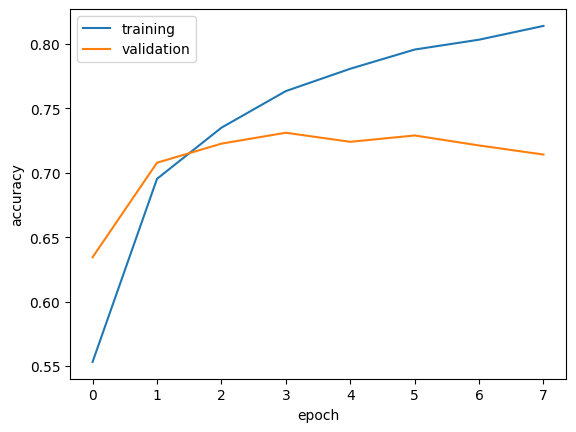

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In [ ]:
test_vec2   = test_title.map(vectorize_text)
model_t.evaluate(test_vec2), model_t.evaluate(test_vec1)

709/709 [==============================] - 2s 3ms/step - loss: 0.7353 - accuracy: 0.6855


([0.30969351530075073, 0.8930867910385132],
 [0.7352541089057922, 0.6854724884033203])

In [ ]:
# content
content = merge[['content', 'Sentiment']]
content.rename(columns = {'content': 'Sentence'}, inplace = True)
data_c = pd.concat([fin_data, content], axis = 0)
data_c = data_c.reset_index()
data_c.drop(columns = 'index', inplace = True)
data_c = data_c.sample(frac=1)

le = LabelEncoder()
data_c['Category'] = le.fit_transform(data_c['Sentiment'])

# title test
content_test = test[['content', 'Sentiment']]
content_test.rename(columns = {'content' : 'Sentence'}, inplace = True)

# labeling test set
content_test['Category'] = le.fit_transform(title_test['Sentiment']) + 2

data_content = make_dataset(stop, data_c)
test_content = make_dataset(stop, content_test)

data_content = data_content.shuffle(buffer_size = len(data_title), reshuffle_each_iteration=False)
train_size = int(0.7*len(data_content))
train = data_title.take(train_size)
val = data_title.skip(train_size)

train_vec = train.map(vectorize_text)
val_vec   = val.map(vectorize_text)

# Model
model_c = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 10, name="embedding"),
  layers.Dropout(0.2), # one of the regularization
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(3)]
)

In [ ]:
# compile and history
model_c.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model_c.fit(train_vec, epochs = 10, validation_data = val_vec, callbacks=[callback], verbose = True)

Epoch 1/10
4959/4959 [==============================] - 25s 5ms/step - loss: 0.9386 - accuracy: 0.5616 - val_loss: 0.8702 - val_accuracy: 0.6599
Epoch 2/10
4959/4959 [==============================] - 21s 4ms/step - loss: 0.7758 - accuracy: 0.6945 - val_loss: 0.7501 - val_accuracy: 0.7112
Epoch 3/10
4959/4959 [==============================] - 22s 5ms/step - loss: 0.6584 - accuracy: 0.7397 - val_loss: 0.6937 - val_accuracy: 0.7164
Epoch 4/10
4959/4959 [==============================] - 22s 4ms/step - loss: 0.5847 - accuracy: 0.7643 - val_loss: 0.6627 - val_accuracy: 0.7267
Epoch 5/10
4959/4959 [==============================] - 22s 4ms/step - loss: 0.5326 - accuracy: 0.7798 - val_loss: 0.6510 - val_accuracy: 0.7305
Epoch 6/10
4959/4959 [==============================] - 21s 4ms/step - loss: 0.4915 - accuracy: 0.7913 - val_loss: 0.6537 - val_accuracy: 0.7239
Epoch 7/10
4959/4959 [==============================] - 23s 5ms/step - loss: 0.4701 - accuracy: 0.7994 - val_loss: 0.6586 - val_ac

In [ ]:
test_vec   = test_title.map(vectorize_text)
model_c.evaluate(test_vec)

1244/1244 [==============================] - 3s 2ms/step - loss: 0.3220 - accuracy: 0.8842


[0.3219911754131317, 0.8842443823814392]

In [ ]:
# LSTM